## Especialização em Ciência de Dados - PUCRS - 2020
## Trabalho de Conclusão do Curso
# Classificação da evolução de casos e mortes na pandemia de COVID-19
### Orientando: Luciano Witt Gonçalves
### Orientador: Juliano Gomes da Silveira
### Dataset: UNCOVER COVID-19 Challenge - Roche Data Science Coalition - Kagge.com

https://www.kaggle.com/roche-data-science-coalition/uncover/data

Última atualização do dataset: 24/07/2020

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Países selecionados para análise visual do dataset

In [2]:
subject_countries = ['BRA','ESP','DEU','ITA','CHN','GBR','USA']

Dataset da distribuição de casos e mortes por COVID-19 no mundo

In [3]:
df = pd.read_csv('data\COVID-19-geographic-distribution-worldwide-2020-07-24.csv', ';')
df.dropna(inplace=True)
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,24/07/2020,24,7,2020,13,0,Afghanistan,AF,AFG,38041757.0,Asia,"5,30995453"
1,23/07/2020,23,7,2020,188,21,Afghanistan,AF,AFG,38041757.0,Asia,"5,9460976"
2,22/07/2020,22,7,2020,112,4,Afghanistan,AF,AFG,38041757.0,Asia,"5,60699654"
3,21/07/2020,21,7,2020,140,5,Afghanistan,AF,AFG,38041757.0,Asia,"5,8646082"
4,20/07/2020,20,7,2020,174,17,Afghanistan,AF,AFG,38041757.0,Asia,"6,63481448"


Adicionadas colunas com acumuladores de casos e mortes, pois o dataset original tinha apenas os números novos a cada dia. Algumas colunas foram renomeadas para facilitar a visualização

In [4]:
df.drop(columns=['day','month','year','geoId','continentExp','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'], inplace=True)
df.rename(columns={'dateRep':'date','countriesAndTerritories':'country','countryterritoryCode':'code','popData2019':'pop'}, inplace=True)
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.sort_values(by=['code','date'], ascending=True, inplace=True)
df['total_cases'] = df.groupby(by='code')['cases'].cumsum()
df['total_deaths'] = df.groupby(by='code')['deaths'].cumsum()
df.head()

,date,cases,deaths,country,code,pop,total_cases,total_deaths
1490,2020-04-05,2,0,Aruba,ABW,106310.0,2,0
1489,2020-04-06,0,0,Aruba,ABW,106310.0,2,0
1488,2020-04-07,7,0,Aruba,ABW,106310.0,9,0
1487,2020-04-08,3,0,Aruba,ABW,106310.0,12,0
1486,2020-04-09,3,0,Aruba,ABW,106310.0,15,0


Abaixo os gráficos dos totais de casos e mortes no tempo

In [5]:
def setupDatetimeAxis(ax):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B-%Y"))

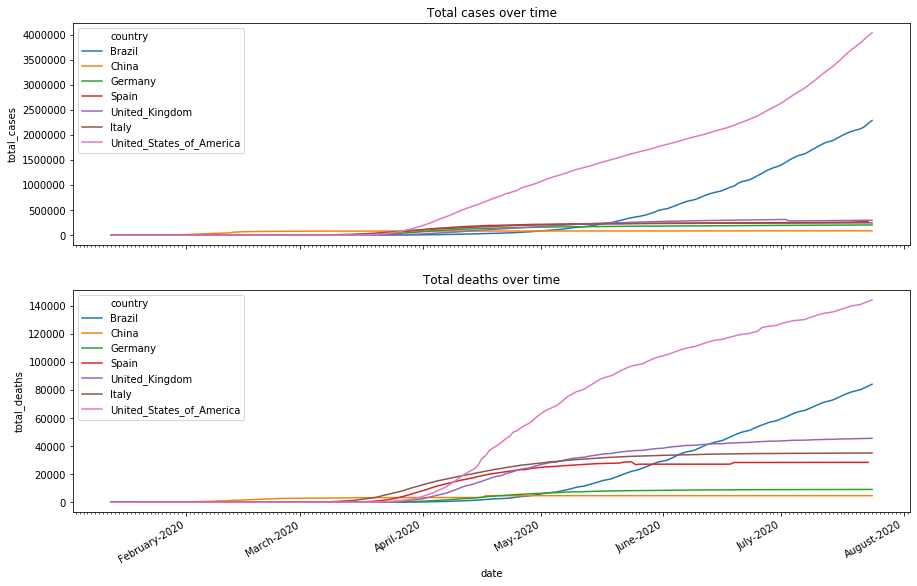

In [6]:
df_vis = df.loc[df['code'].isin(subject_countries)]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))

ax1.set_title('Total cases over time')
setupDatetimeAxis(ax1)
sns.lineplot(x='date', y='total_cases', hue='country', data=df_vis, ax=ax1, sort=False)

ax2.set_title('Total deaths over time')
setupDatetimeAxis(ax2)
sns.lineplot(x='date', y='total_deaths', hue='country', data=df_vis, ax=ax2, sort=False)

fig.autofmt_xdate()
plt.show()

Como os casos começaram a aparecer em datas diferentes em cada país, não faz muito sentido comparar dados na mesma data, mas sim no mesmo tempo decorrido desde o primeiro caso de cada país, então vamos calcular, para cada país, os totais por semana, desde o primeiro caso do respectivo país

Primeiramente removemos os registros anteriores ao primeiro caso de cada país

In [7]:
df2 = df.copy()
df2 = df2[df2['total_cases'] > 0]
df2.sort_values(by=['code','date'], ascending=True, inplace=True)

Então, para cada registro, calculamos a semana relativa ao primeiro caso deste país

In [8]:
df2['min_date'] = df2.groupby(by='code')['date'].transform('min')
df2['days_passed'] = df2['date'] - df2['min_date']
df2['week'] = (df2['days_passed'] / np.timedelta64(1, 'W')).astype(int) + 1

Finalmente, calculamos o total de cada semana, e descartamos registros duplicados, deixando somente um registro por semana contendo os respetivos totais

In [9]:
df2 = df2.drop(columns=['date','cases','deaths','min_date','days_passed'])
df2['max_total_cases'] = df2.groupby(by=['code','week'])['total_cases'].transform(max)
df2['max_total_deaths'] = df2.groupby(by=['code','week'])['total_deaths'].transform(max)
df2 = df2.drop(columns=['total_cases','total_deaths'])
df2 = df2.rename(columns={'max_total_cases':'total_cases','max_total_deaths':'total_deaths'})
df2.drop_duplicates(inplace=True)
df2[df2['code']=='BRA'].head(10)

,country,code,pop,week,total_cases,total_deaths
4279,Brazil,BRA,211049519.0,1,2,0
4272,Brazil,BRA,211049519.0,2,25,0
4265,Brazil,BRA,211049519.0,3,234,0
4258,Brazil,BRA,211049519.0,4,1891,34
4251,Brazil,BRA,211049519.0,5,4579,159
4244,Brazil,BRA,211049519.0,6,12056,553
4237,Brazil,BRA,211049519.0,7,23430,1328
4230,Brazil,BRA,211049519.0,8,40581,2575
4223,Brazil,BRA,211049519.0,9,66501,4543
4216,Brazil,BRA,211049519.0,10,107780,7321


Abaixo os gráficos dos totais de casos e mortes por semana, desde o primeiro caso, para cada país

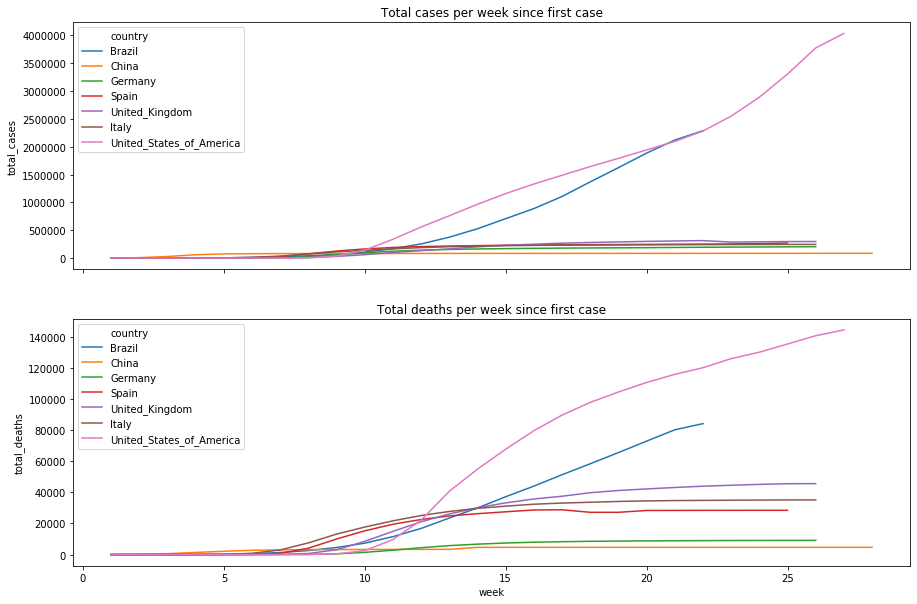

In [10]:
df_vis = df2.loc[df['code'].isin(subject_countries)]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))

ax1.set_title('Total cases per week since first case')
sns.lineplot(x='week', y='total_cases', hue='country', data=df_vis, ax=ax1)

ax2.set_title('Total deaths per week since first case')
sns.lineplot(x='week', y='total_deaths', hue='country', data=df_vis, ax=ax2)

plt.show()

Os dados calculados até o momento são números absolutos, porém esses países têm populações diferentes, então vamos calcular os números per capita para uma comparação mais proporcional

In [11]:
df3 = df2.copy()
df3['total_cases_100k'] = df3['total_cases'] * 100000 / df3['pop']
df3['total_deaths_100k'] = df3['total_deaths'] * 100000 / df3['pop']
df3.drop(columns=['code','pop','total_cases','total_deaths'], inplace=True)
df3.rename(columns={'total_cases_100k':'total_cases','total_deaths_100k':'total_deaths'}, inplace=True)
df3.head(12)

,country,week,total_cases,total_deaths
1490,Aruba,1,22.575487,0.000000
1483,Aruba,2,31.981940,1.881291
1476,Aruba,3,35.744521,1.881291
1469,Aruba,4,35.744521,1.881291
1462,Aruba,5,36.685166,2.821936
1455,Aruba,6,36.685166,2.821936
1448,Aruba,7,36.685166,2.821936
1441,Aruba,8,36.685166,2.821936
1434,Aruba,9,36.685166,2.821936
1427,Aruba,10,36.685166,2.821936


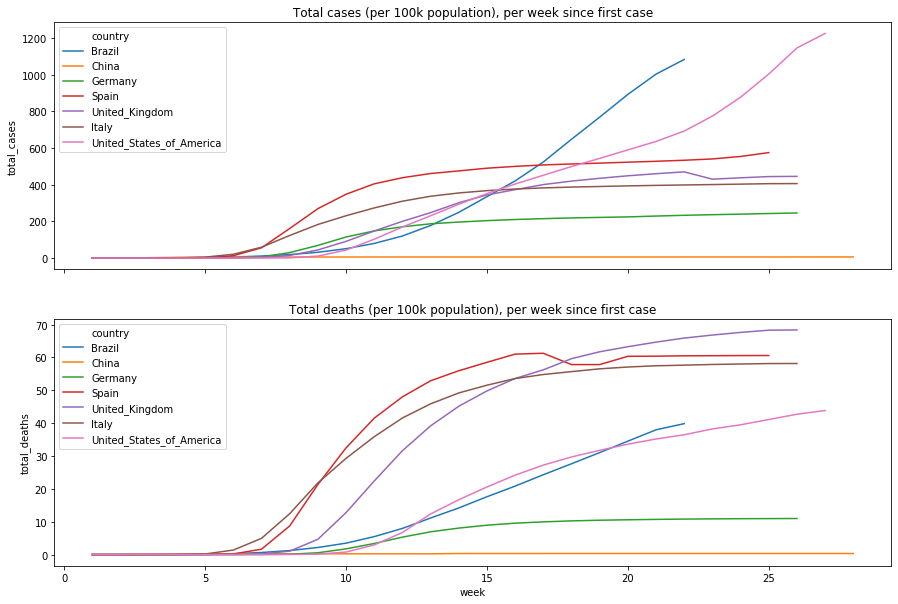

In [12]:
df_vis = df3.loc[df['code'].isin(subject_countries)]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))

ax1.set_title('Total cases (per 100k population), per week since first case')
sns.lineplot(x='week', y='total_cases', hue='country', data=df_vis, ax=ax1)

ax2.set_title('Total deaths (per 100k population), per week since first case')
sns.lineplot(x='week', y='total_deaths', hue='country', data=df_vis, ax=ax2)

plt.show()

In [13]:
df3.to_csv('data\COVID-19-numbers-per-week-since-1st-case-until-2020-07-24.csv', ';', index=False)

# Indicadores

In [14]:
df_hw = pd.read_csv('data\WHO_Population_with_basic_handwashing_facilities_at_home.csv')
df_hw.head()

,Location,Indicator,Period,Dim1,First Tooltip
0,Afghanistan,Population with basic handwashing facilities a...,2017,Total,37.75
1,Afghanistan,Population with basic handwashing facilities a...,2017,Urban,63.58
2,Afghanistan,Population with basic handwashing facilities a...,2017,Rural,29.02
3,Afghanistan,Population with basic handwashing facilities a...,2016,Total,37.67
4,Afghanistan,Population with basic handwashing facilities a...,2016,Urban,63.58


In [15]:
df_hw = df_hw.loc[df_hw['Period'] == df_hw['Period'].max()]
df_hw = df_hw.loc[df_hw['Dim1'] == 'Total'][['Location','First Tooltip']]
df_hw.rename(columns={'Location': 'country', 'First Tooltip': 'hw'}, inplace=True)
df_hw.dropna(inplace=True)
df_hw['hw'] = df_hw['hw'] / 100
df_hw.set_index(['country'], inplace=True)
df_hw.head()

,hw
country,
Afghanistan,0.3775
Algeria,0.8374
Angola,0.2666
Armenia,0.9404
Azerbaijan,0.8324


In [16]:
df_gdp = pd.read_csv('data\API_NY.GDP.MKTP.PP.CD_DS2_en_csv_v2_1069861.csv')
df_gdp.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.502846e+09,3.443754e+09,3.596191e+09,3.623628e+09,3.536556e+09,3.496393e+09,3.578912e+09,NaN,NaN,NaN
1,Afghanistan,AFG,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5.118418e+10,5.966700e+10,6.503984e+10,6.905834e+10,7.183170e+10,7.533026e+10,7.994539e+10,8.273686e+10,NaN,NaN
2,Angola,AGO,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.625388e+11,1.864274e+11,2.001376e+11,2.203594e+11,2.046388e+11,2.049368e+11,2.179873e+11,2.185333e+11,NaN,NaN
3,Albania,ALB,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.965540e+10,3.053033e+10,3.060407e+10,3.252920e+10,3.359487e+10,3.473647e+10,3.762405e+10,3.965788e+10,NaN,NaN
4,Andorra,AND,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_gdp = df_gdp[['Country Name','2018']]
df_gdp.rename(columns={'Country Name': 'country', '2018': 'gdp'}, inplace=True)
df_gdp.dropna(inplace=True)
df_gdp.set_index(['country'], inplace=True)
df_gdp.head()

,gdp
country,
Afghanistan,8.273686e+10
Angola,2.185333e+11
Albania,3.965788e+10
Arab World,6.249507e+12
United Arab Emirates,6.505677e+11


In [18]:
df_hdi = pd.read_csv('data\Human development index (HDI).csv')
df_hdi.head()

,HDI Rank (2018),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,170,Afghanistan,0.298,0.304,0.312,0.308,0.303,0.327,0.331,0.335,...,0.447,0.464,0.465,0.479,0.485,0.488,0.490,0.491,0.493,0.496
1,69,Albania,0.644,0.625,0.608,0.611,0.617,0.629,0.639,0.639,...,0.729,0.740,0.759,0.771,0.781,0.787,0.788,0.788,0.789,0.791
2,82,Algeria,0.578,0.582,0.589,0.593,0.597,0.602,0.610,0.619,...,0.720,0.730,0.738,0.737,0.746,0.749,0.751,0.755,0.758,0.759
3,36,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.830,0.828,0.827,0.849,0.846,0.853,0.850,0.854,0.852,0.857
4,149,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.508,0.510,0.525,0.537,0.547,0.557,0.565,0.570,0.576,0.574


In [19]:
df_hdi = df_hdi[['Country','2018']]
df_hdi.rename(columns={'Country': 'country', '2018': 'hdi'}, inplace=True)
df_hdi.dropna(inplace=True)
df_hdi.set_index(['country'], inplace=True)
df_hdi.head()

,hdi
country,
Afghanistan,0.496
Albania,0.791
Algeria,0.759
Andorra,0.857
Angola,0.574


In [20]:
df_uhc = pd.read_csv('data\WHO_UHC_index_of_essential_service_coverage.csv')
df_uhc.head()

,Location,Indicator,Period,First Tooltip
0,Afghanistan,UHC index of essential service coverage (%),2017,0.37
1,Afghanistan,UHC index of essential service coverage (%),2015,0.34
2,Albania,UHC index of essential service coverage (%),2017,0.59
3,Albania,UHC index of essential service coverage (%),2015,0.58
4,Algeria,UHC index of essential service coverage (%),2017,0.78


In [21]:
df_uhc = df_uhc.loc[df_uhc['Period'] == df_uhc['Period'].max()]
df_uhc = df_uhc[['Location','First Tooltip']]
df_uhc.rename(columns={'Location': 'country', 'First Tooltip': 'uhc'}, inplace=True)
df_uhc.dropna(inplace=True)
df_uhc.set_index(['country'], inplace=True)
df_uhc.head()

,uhc
country,
Afghanistan,0.37
Albania,0.59
Algeria,0.78
Angola,0.40
Antigua and Barbuda,0.73


In [22]:
df_pop_total = pd.read_csv('data\API_SP.POP.TOTL_DS2_en_csv_v2_1217749.csv')
df_pop_total.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,106314.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,38041754.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,31825295.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,77142.0,NaN


In [23]:
df_pop_total = df_pop_total[['Country Name','2018']]
df_pop_total.rename(columns={'Country Name': 'country', '2018': 'pop_total'}, inplace=True)
df_pop_total.dropna(inplace=True)
df_pop_total.set_index(['country'], inplace=True)
df_pop_total.head()

,pop_total
country,
Aruba,105845.0
Afghanistan,37172386.0
Angola,30809762.0
Albania,2866376.0
Andorra,77006.0


In [24]:
df_pop_00_14 = pd.read_csv('data\API_SP.POP.0014.TO_DS2_en_csv_v2_1004418.csv')
df_pop_00_14.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Population ages 0-14, total",SP.POP.0014.TO,23770.0,24037.0,24135.0,24089.0,23925.0,23684.0,...,21222.0,20951.0,20607.0,20212.0,19833.0,19515.0,19147.0,18945.0,18843.0,NaN
1,Afghanistan,AFG,"Population ages 0-14, total",SP.POP.0014.TO,3791401.0,3892776.0,3987207.0,4079606.0,4176101.0,4279406.0,...,14061036.0,14366485.0,14673817.0,14968788.0,15230627.0,15443806.0,15664859.0,15855184.0,16017646.0,NaN
2,Angola,AGO,"Population ages 0-14, total",SP.POP.0014.TO,2298276.0,2366959.0,2439522.0,2504084.0,2547459.0,2565874.0,...,10987155.0,11418718.0,11849944.0,12280860.0,12710366.0,13136045.0,13571356.0,13999863.0,14421718.0,NaN
3,Albania,ALB,"Population ages 0-14, total",SP.POP.0014.TO,646025.0,672912.0,699944.0,726429.0,751660.0,774509.0,...,654121.0,623783.0,597500.0,574857.0,555294.0,537791.0,528734.0,518036.0,506571.0,NaN
4,Andorra,AND,"Population ages 0-14, total",SP.POP.0014.TO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_pop_00_14 = df_pop_00_14[['Country Name','2018']]
df_pop_00_14.rename(columns={'Country Name': 'country', '2018': 'pop_0_14'}, inplace=True)
df_pop_00_14.dropna(inplace=True)
df_pop_00_14.set_index(['country'], inplace=True)
df_pop_00_14.head()

,pop_0_14
country,
Aruba,18843.0
Afghanistan,16017646.0
Angola,14421718.0
Albania,506571.0
Arab World,137609185.0


In [26]:
df_pop_15_64 = pd.read_csv('data\API_SP.POP.1564.TO_DS2_en_csv_v2_1004520.csv')
df_pop_15_64.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Population ages 15-64, total",SP.POP.1564.TO,29095.0,29968.0,30577.0,31018.0,31436.0,31910.0,...,69987.0,70295.0,70753.0,71292.0,71792.0,72162.0,72506.0,72646.0,72659.0,NaN
1,Afghanistan,AFG,"Population ages 15-64, total",SP.POP.1564.TO,4953809.0,5019145.0,5102009.0,5197709.0,5300287.0,5407208.0,...,14444994.0,15041825.0,15743957.0,16519810.0,17322057.0,18116800.0,18826642.0,19514114.0,20193861.0,NaN
2,Angola,AGO,"Population ages 15-64, total",SP.POP.1564.TO,2992630.0,2996073.0,2997144.0,3000938.0,3011480.0,3028008.0,...,11817707.0,12233380.0,12671465.0,13130630.0,13610932.0,14113726.0,14618994.0,15149230.0,15705184.0,NaN
3,Albania,ALB,"Population ages 15-64, total",SP.POP.1564.TO,875725.0,897410.0,918872.0,940393.0,963492.0,988506.0,...,1948797.0,1961405.0,1972618.0,1979460.0,1981897.0,1979179.0,1974734.0,1972416.0,1965829.0,NaN
4,Andorra,AND,"Population ages 15-64, total",SP.POP.1564.TO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_pop_15_64 = df_pop_15_64[['Country Name','2018']]
df_pop_15_64.rename(columns={'Country Name': 'country', '2018': 'pop_15_64'}, inplace=True)
df_pop_15_64.dropna(inplace=True)
df_pop_15_64.set_index(['country'], inplace=True)
df_pop_15_64.head()

,pop_15_64
country,
Aruba,72659.0
Afghanistan,20193861.0
Angola,15705184.0
Albania,1965829.0
Arab World,263047867.0


In [28]:
df_pop_65plus= pd.read_csv('data\API_SP.POP.65UP.TO_DS2_en_csv_v2_993674.csv')
df_pop_65plus.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Population ages 65 and above, total",SP.POP.65UP.TO,1346.0,1433.0,1513.0,1588.0,1671.0,1766.0,...,10460.0,10800.0,11200.0,11655.0,12149.0,12664.0,13219.0,13775.0,14343.0,NaN
1,Afghanistan,AFG,"Population ages 65 and above, total",SP.POP.65UP.TO,251763.0,257489.0,262225.0,265890.0,268393.0,269706.0,...,679477.0,709103.0,743602.0,780991.0,818110.0,852997.0,891627.0,927101.0,960879.0,NaN
2,Angola,AGO,"Population ages 65 and above, total",SP.POP.65UP.TO,164027.0,168440.0,171873.0,174436.0,176105.0,176688.0,...,551384.0,568563.0,586522.0,604290.0,620481.0,634610.0,652134.0,667656.0,682859.0,NaN
3,Albania,ALB,"Population ages 65 and above, total",SP.POP.65UP.TO,87049.0,89478.0,92504.0,95799.0,98983.0,101776.0,...,310103.0,320007.0,330283.0,340775.0,351913.0,363733.0,372634.0,383005.0,393976.0,NaN
4,Andorra,AND,"Population ages 65 and above, total",SP.POP.65UP.TO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_pop_65plus = df_pop_65plus[['Country Name','2018']]
df_pop_65plus.rename(columns={'Country Name': 'country', '2018': 'pop_65+'}, inplace=True)
df_pop_65plus.dropna(inplace=True)
df_pop_65plus.set_index(['country'], inplace=True)
df_pop_65plus.head()

,pop_65+
country,
Aruba,14343.0
Afghanistan,960879.0
Angola,682859.0
Albania,393976.0
Arab World,19133535.0


In [30]:
df_pop = df_pop_total.join(df_pop_00_14, on='country').join(df_pop_15_64, on='country').join(df_pop_65plus, on='country')
df_pop.dropna(inplace=True)
df_pop.head()

,pop_total,pop_0_14,pop_15_64,pop_65+
country,,,,
Aruba,105845.0,18843.0,72659.0,14343.0
Afghanistan,37172386.0,16017646.0,20193861.0,960879.0
Angola,30809762.0,14421718.0,15705184.0,682859.0
Albania,2866376.0,506571.0,1965829.0,393976.0
Arab World,419790591.0,137609185.0,263047867.0,19133535.0


In [31]:
df_pop['pop_0_14'] = df_pop['pop_0_14'] / df_pop['pop_total']
df_pop['pop_15_64'] = df_pop['pop_15_64'] / df_pop['pop_total']
df_pop['pop_65+'] = df_pop['pop_65+'] / df_pop['pop_total']
df_pop.drop(columns=['pop_total'], inplace=True)
df_pop.head()

,pop_0_14,pop_15_64,pop_65+
country,,,
Aruba,0.178024,0.686466,0.135509
Afghanistan,0.430902,0.543249,0.025849
Angola,0.468089,0.509747,0.022164
Albania,0.176729,0.685824,0.137447
Arab World,0.327804,0.626617,0.045579


In [32]:
df_ind = df_hw.join(df_uhc).join(df_pop).join(df_gdp).join(df_hdi)
df_ind.dropna(inplace=True)
df_ind.head()

,hw,uhc,pop_0_14,pop_15_64,pop_65+,gdp,hdi
country,,,,,,,
Afghanistan,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496
Algeria,0.8374,0.78,0.301487,0.634888,0.063625,4.965724e+11,0.759
Angola,0.2666,0.40,0.468089,0.509747,0.022164,2.185333e+11,0.574
Armenia,0.9404,0.69,0.206334,0.681128,0.112538,3.844596e+10,0.760
Azerbaijan,0.8324,0.65,0.233696,0.704355,0.061952,1.445564e+11,0.754


In [33]:
df4 = df3.join(df_ind, on=['country'])
df4.rename(columns={'total_cases':'cases','total_deaths':'deaths'}, inplace=True)
df4.dropna(inplace=True)
df4.head()

,country,week,cases,deaths,hw,uhc,pop_0_14,pop_15_64,pop_65+,gdp,hdi
140,Afghanistan,1,0.002629,0.000000,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496
133,Afghanistan,2,0.010515,0.000000,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496
132,Afghanistan,3,0.042059,0.000000,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496
129,Afghanistan,4,0.089375,0.000000,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496
122,Afghanistan,5,0.299671,0.010515,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496


In [34]:
df5 = df4.copy()
df5['prev_cases'] = df5.groupby(['country'])['cases'].shift(1, fill_value=0)
df5['prev_deaths'] = df5.groupby(['country'])['deaths'].shift(1, fill_value=0)
df5.head()

,country,week,cases,deaths,hw,uhc,pop_0_14,pop_15_64,pop_65+,gdp,hdi,prev_cases,prev_deaths
140,Afghanistan,1,0.002629,0.000000,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496,0.000000,0.0
133,Afghanistan,2,0.010515,0.000000,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496,0.002629,0.0
132,Afghanistan,3,0.042059,0.000000,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496,0.010515,0.0
129,Afghanistan,4,0.089375,0.000000,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496,0.042059,0.0
122,Afghanistan,5,0.299671,0.010515,0.3775,0.37,0.430902,0.543249,0.025849,8.273686e+10,0.496,0.089375,0.0


In [35]:
df_final = df5[['country','gdp','hdi','uhc','hw','pop_0_14','pop_15_64','pop_65+','week','prev_cases','prev_deaths','cases','deaths']]
df_final.head(10)

,country,gdp,hdi,uhc,hw,pop_0_14,pop_15_64,pop_65+,week,prev_cases,prev_deaths,cases,deaths
140,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,1,0.000000,0.000000,0.002629,0.000000
133,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,2,0.002629,0.000000,0.010515,0.000000
132,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,3,0.010515,0.000000,0.042059,0.000000
129,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,4,0.042059,0.000000,0.089375,0.000000
122,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,5,0.089375,0.000000,0.299671,0.010515
115,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,6,0.299671,0.010515,0.785978,0.018401
108,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,7,0.785978,0.018401,1.595615,0.047316
101,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,8,1.595615,0.047316,2.618176,0.086747
94,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,9,2.618176,0.086747,4.024525,0.149835
87,Afghanistan,8.273686e+10,0.496,0.37,0.3775,0.430902,0.543249,0.025849,10,4.024525,0.149835,7.107979,0.223439


In [36]:
df_final.to_csv('data\COVID-19-final.csv', ';')